<a href="https://colab.research.google.com/github/mjwagerman/mth4133-ml-project/blob/main/Linear_Regression_Sandbox_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# If running on a clean environment, uncomment these:
%pip install openml xgboost --quiet

import numpy as np
import pandas as pd
import openml
from sklearn.model_selection import train_test_split, cross_val_score, LearningCurveDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# XGBoost (sklearn API)
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.0 MB/s eta 0:00:00


In [3]:
# B1) Load fixed OpenML dataset (DID=8)
import openml
import pandas as pd
import numpy as np

DATASET_ID = 8  # liver-disorders (BUPA)
dataset = openml.datasets.get_dataset(DATASET_ID, download_data=True)

# We'll *explicitly* choose the regression target = 'drinks'
# and then drop the notorious 'selector' column from the features.
X_all, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="dataframe",
    target="drinks"  # numeric target for regression
)

# If 'selector' is present, remove it from X
if "selector" in X_all.columns:
    X_all = X_all.drop(columns=["selector"])

print(f"Dataset: {dataset.name} (DID={DATASET_ID})")
print(f"Rows: {len(X_all)}, Features: {X_all.shape[1]}")
print("Columns:", list(X_all.columns))
print("Target dtype:", pd.Series(y).dtype)

display(X_all.head())
display(pd.Series(y).describe())


Dataset: liver-disorders (DID=8)
Rows: 345, Features: 5
Columns: ['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt']
Target dtype: float64


,mcv,alkphos,sgpt,sgot,gammagt
0,85,92,45,27,31
1,85,64,59,32,23
2,86,54,33,16,54
3,91,78,34,24,36
4,87,70,12,28,10


,drinks
count,345.000000
mean,3.455072
std,3.337835
min,0.000000
25%,0.500000
50%,3.000000
75%,6.000000
max,20.000000


In [5]:
# B2) Train/Val/Test split (60/20/20) — keep a clean final test set
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_all, y, test_size=0.20, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=RANDOM_STATE
)  # 0.8 * 0.25 = 0.20


In [6]:
# B3) Preprocessing pipeline (impute + scale numeric)
# This dataset is all numeric, but we'll keep a robust pipeline for consistency across models.
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_cols = list(X_train.columns)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler())
        ]), num_cols)
    ],
    remainder="drop"
)

# Fit once on train; transform train/val/test
X_train_proc = preprocess.fit_transform(X_train, y_train)
X_val_proc   = preprocess.transform(X_val)
X_test_proc  = preprocess.transform(X_test)

# For your manual GD/SGD sections, add an intercept column
def add_intercept(M):
    if hasattr(M, "toarray"):
        M = M.toarray()
    return np.c_[np.ones((M.shape[0], 1)), M]

X_train_b = add_intercept(X_train_proc)
X_val_b   = add_intercept(X_val_proc)
X_test_b  = add_intercept(X_test_proc)

X_train_b.shape, X_val_b.shape, X_test_b.shape


((207, 6), (69, 6), (69, 6))

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error as sk_mse
from sklearn.metrics import mean_absolute_error as sk_mae
from sklearn.metrics import r2_score as sk_r2

def evaluate_and_report(name, pipe, X_tr, y_tr, X_val, y_val, X_te, y_te, results):
    pipe.fit(X_tr, y_tr)
    preds_tr  = pipe.predict(X_tr)
    preds_val = pipe.predict(X_val)
    preds_te  = pipe.predict(X_te)

    def metrics(y_true, y_pred):
        mae  = sk_mae(y_true, y_pred)
        rmse = np.sqrt(sk_mse(y_true, y_pred))  # avoid squared kwarg
        r2   = sk_r2(y_true, y_pred)
        return {"MAE": mae, "RMSE": rmse, "R2": r2}

    m_tr  = metrics(y_tr, preds_tr)
    m_val = metrics(y_val, preds_val)
    m_te  = metrics(y_te, preds_te)

    print(f"\n{name}")
    print("-"*len(name))
    print("Train:", m_tr)
    print("Val:  ", m_val)
    print("Test: ", m_te)

    row = {
        "Model": name,
        "Train_RMSE": m_tr["RMSE"], "Val_RMSE": m_val["RMSE"], "Test_RMSE": m_te["RMSE"],
        "Train_R2": m_tr["R2"],     "Val_R2": m_val["R2"],     "Test_R2": m_te["R2"],
        "Train_MAE": m_tr["MAE"],   "Val_MAE": m_val["MAE"],   "Test_MAE": m_te["MAE"],
    }
    results.append(row)
    return row


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# XGBoost (optional)
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

results = []

# 1) Linear Regression (closed-form via sklearn)
lr_pipe = Pipeline([
    ("prep", preprocess),
    ("lr", LinearRegression())
])
evaluate_and_report("LinearRegression", lr_pipe, X_train, y_train, X_val, y_val, X_test, y_test, results)

# 2) SGDRegressor (sensitive to scaling; already handled in preprocess)
sgd_pipe = Pipeline([
    ("prep", preprocess),
    ("sgd", SGDRegressor(random_state=RANDOM_STATE, max_iter=2000, tol=1e-3))
])
evaluate_and_report("SGDRegressor", sgd_pipe, X_train, y_train, X_val, y_val, X_test, y_test, results)

# 3) SVR (RBF kernel by default; can be slow on large N but fine here)
svr_pipe = Pipeline([
    ("prep", preprocess),
    ("svr", SVR())  # Students can try: kernel="linear"/"poly", C, epsilon, gamma
])
evaluate_and_report("SVR", svr_pipe, X_train, y_train, X_val, y_val, X_test, y_test, results)

# 4) kNN Regressor
knn_pipe = Pipeline([
    ("prep", preprocess),
    ("knn", KNeighborsRegressor(n_neighbors=5))
])
evaluate_and_report("KNeighborsRegressor(k=5)", knn_pipe, X_train, y_train, X_val, y_val, X_test, y_test, results)

# 5) Decision Tree Regressor
tree_pipe = Pipeline([
    ("prep", preprocess),  # harmless even though trees don't require scaling
    ("tree", DecisionTreeRegressor(random_state=RANDOM_STATE))
])
evaluate_and_report("DecisionTreeRegressor", tree_pipe, X_train, y_train, X_val, y_val, X_test, y_test, results)

# 6) XGBoost Regressor (if available)
if XGB_AVAILABLE:
    xgb_pipe = Pipeline([
        ("prep", preprocess),
        ("xgb", XGBRegressor(
            random_state=RANDOM_STATE,
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            tree_method="hist",
            objective="reg:squarederror",
            verbosity=0
        ))
    ])
    evaluate_and_report("XGBRegressor", xgb_pipe, X_train, y_train, X_val, y_val, X_test, y_test, results)
else:
    print("XGBoost not available; `%pip install xgboost` if you want to include it.")



LinearRegression
----------------
Train: {'MAE': 2.3661464367833416, 'RMSE': np.float64(3.0932793929327858), 'R2': 0.24393592316436874}
Val:   {'MAE': 2.021762171269505, 'RMSE': np.float64(2.5330213047191523), 'R2': 0.07407927543467008}
Test:  {'MAE': 2.608922938359547, 'RMSE': np.float64(3.2650527220197003), 'R2': -0.0014891688059759378}

SGDRegressor
------------
Train: {'MAE': 2.3662519589524544, 'RMSE': np.float64(3.0936111118333067), 'R2': 0.2437737559882499}
Val:   {'MAE': 2.0232467634951368, 'RMSE': np.float64(2.536630863144655), 'R2': 0.07143851892699837}
Test:  {'MAE': 2.597932742263576, 'RMSE': np.float64(3.2434147629455254), 'R2': 0.011740863191012751}

SVR
---
Train: {'MAE': 2.046536228003289, 'RMSE': np.float64(2.9840374106288694), 'R2': 0.2963951342933654}
Val:   {'MAE': 2.1334070757686483, 'RMSE': np.float64(2.7643767194792987), 'R2': -0.10278429714669124}
Test:  {'MAE': 2.2958611726642135, 'RMSE': np.float64(2.9776279351624817), 'R2': 0.167073421786762}

KNeighborsRegr

In [12]:
import pandas as pd

results_df = pd.DataFrame(results)
# Sort by Validation RMSE (primary) then Test RMSE
results_df = results_df.sort_values(by=["Val_RMSE", "Test_RMSE"]).reset_index(drop=True)
results_df


,Model,Train_RMSE,Val_RMSE,Test_RMSE,Train_R2,Val_R2,Test_R2,Train_MAE,Val_MAE,Test_MAE
0,LinearRegression,3.093279,2.533021,3.265053,0.243936,0.074079,-0.001489,2.366146,2.021762,2.608923
1,SGDRegressor,3.093611,2.536631,3.243415,0.243774,0.071439,0.011741,2.366252,2.023247,2.597933
2,SVR,2.984037,2.764377,2.977628,0.296395,-0.102784,0.167073,2.046536,2.133407,2.295861
3,KNeighborsRegressor(k=5),2.653445,2.856901,3.209406,0.443660,-0.177841,0.032357,2.059903,2.218841,2.513043
4,XGBRegressor,0.133226,2.895045,3.210380,0.998598,-0.209503,0.031770,0.096227,2.284368,2.526295
5,DecisionTreeRegressor,0.000000,3.853288,5.183586,1.000000,-1.142688,-1.524216,0.000000,3.043478,3.797101


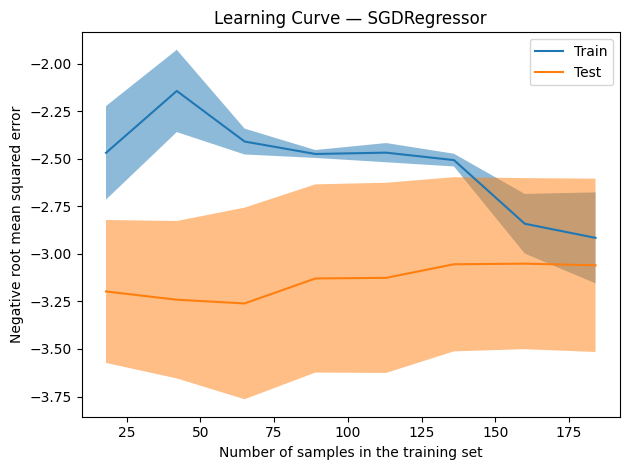

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay

sgd_for_lc = Pipeline([
    ("prep", preprocess),
    ("sgd", SGDRegressor(random_state=RANDOM_STATE, max_iter=2000, tol=1e-3))
])

_ = LearningCurveDisplay.from_estimator(
    sgd_for_lc,
    X_trainval, y_trainval,
    train_sizes=np.linspace(0.1, 1.0, 8),
    scoring="neg_root_mean_squared_error",
    cv=3
)
plt.title("Learning Curve — SGDRegressor")
plt.tight_layout()
plt.show()
